# The EM algorithm

##### Keywords: maximum likelihood, mixture model, ELBO, full-data likelihood, x-likelihood, latent variables, log-likelihood, training set, normal distribution, z-posterior

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

$$\newcommand{\isum}{\sum_{i}}$$
$$\newcommand{\zsum}{\sum_{k=1}^{K}}$$
$$\newcommand{\zsumi}{\sum_{\{z_i\}}}$$

## A toy problem

This example is taken from Efron and Hastie, Computer Age Statistical Inference.

Assume we have data drawn from a bi-variate Normal

![](images/gform1.png)


In [2]:
sig1=1
sig2=0.75
mu1=1.85
mu2=1
rho=0.82
means=np.array([mu1, mu2])
cov = np.array([
    [sig1**2, sig1*sig2*rho],
    [sig2*sig1*rho, sig2**2]
])
print("True Values")
print("Means:\n", means)
print("Covariance Matrix:\n", cov)

True Values
Means:
 [ 1.85  1.  ]
Covariance Matrix:
 [[ 1.      0.615 ]
 [ 0.615   0.5625]]


We sample some points from this distribution:

In [3]:
samples=np.random.multivariate_normal(means, cov, size=40)

We plot the samples below as blue circles. 

**But wait!** Suppose y-values of the last-20 pieces of data. We are left with a missing data or hidden data or latent-variables problem. We plot both datasets below, with the y-values of the lost points set to 0

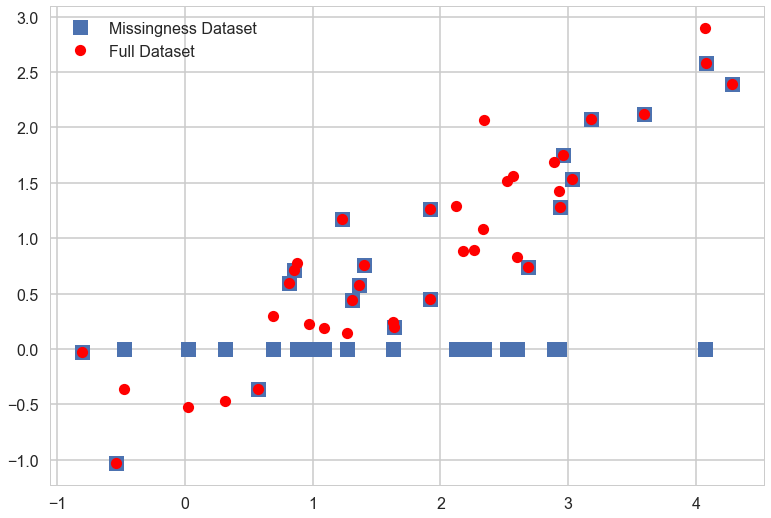

In [4]:
samples_censored=np.copy(samples)
samples_censored[20:,1]=0
plt.plot(samples_censored[:,0], samples_censored[:,1], 's', markersize=15, alpha=1, label="Missingness Dataset")
plt.plot(samples[:,0], samples[:,1], 'o', c='red',  alpha=1, label="Full Dataset")
plt.legend();


We would use MLE if we had all the data. 

![](images/gform2.png)

In [5]:
mu1 = lambda s: np.mean(s[:,0])
mu2 = lambda s: np.mean(s[:,1])
s1 = lambda s: np.std(s[:,0])
s2 = lambda s: np.std(s[:,1])
rho = lambda s: np.mean((s[:,0] - mu1(s))*(s[:,1] - mu2(s)))/(s1(s)*s2(s))

But we don't have all the data, so running everything through the MLE estimators is out.

We could use only the points for which we have full data, but that's wasting a lot of strength: we have x values for the remaining points, just not y values. How can we get a good estimate of the parameters using all of the data we have?

### Iterative Solution: EM (Expectation/Maximization)
We shall follow an iterative process to find good estimates for the data. In Gibbs sampling we picked an initial guess and went back and forth between two update process. EM has the same two-step flavor, but a different justifcation.

#### M Step (estimte the parameters)
To start, we impute 0 for all of the missing values (this seems insane, but it will ultimately matter about as much as the starting point in gradient descent). Then we just go ahead and find the MLE estimates.

In [6]:
mu1s=[]
mu2s=[]
s1s=[]
s2s=[]
rhos=[]

mu1s.append(mu1(samples_censored))
mu2s.append(mu2(samples_censored))
s1s.append(s1(samples_censored))
s2s.append(s2(samples_censored))
rhos.append(rho(samples_censored))

print("Means:\n",mu1s[0],mu2s[0])
print("SDs:\n",s1s[0],s2s[0])
print("Correlation:\n",rhos[0])

Means:
 1.84037225001 0.48065176832
SDs:
 1.24890962772 0.804534434368
Correlation:
 0.599613302922


The estimates above are definitely terrible: the X mean and SD might be okay, but everything else is badly biased by all the zeros in Y.

#### E step (estimate the missing data)
But, since we have parameter estimates, maybe we could fill in the missing data with guesses that are better than "all zero". 

One way to fill values is to write down the expected value of Y at each X value where y is missing. Since we know that X and Y are jointly normal with [something like] the parameters above, we can find the conditional distribution of Y|X. See [wikipedia](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions) for the formulae.

But Y|X gives us the distribution of possible Y values at that x. We want a particular Y value, so we just take the mean.
$$z_{i} = E_{p(Z=z \vert \theta, X=x_i)}[z]$$
where we have used the notation $z$ to refer to the missing y values.

Overall, our update rule plugs the $\mu$, $\rho$ and $\sigma$ values into the below:

$$\bar{y}(t+1)  = \hat{\rho}(t)\frac{\hat{\sigma_2}(t)}{\hat{\sigma_1}(t)} \left( \bar{x} - \hat{\mu_1}(t) \right)+ \hat{\mu_2}(t)$$

That is, each $z_i$ (i.e. each missing $y_i$) becomes a best-guess for $y_i$ based on the curent parameters of the joint X,Y distribution, and the matched $x_i$. This is called the E-step as it computes an Expectation to guess the missing data values. 

In [7]:
def ynew(x, mu1, mu2, s1, s2, rho):
    return mu2 + rho*(s2/s1)*(x - mu1)

In [8]:
newys=ynew(samples_censored[20:,0], mu1s[0], mu2s[0], s1s[0], s2s[0], rhos[0])

#update the state
mu1s.append(mu1(samples_censored))
mu2s.append(mu2(samples_censored))
s1s.append(s1(samples_censored))
s2s.append(s2(samples_censored))
rhos.append(rho(samples_censored))

print("New estimates of missing Y values:\n",newys)

New estimates of missing Y values:
 [ 1.34068363  0.25859661  0.88678257  0.89991922  0.61132661  0.14621847
  0.58972341  0.39867209  0.67106885  0.19055872 -0.10911032  0.03605394
  0.64302411  0.10918825  0.76263016 -0.41417506  0.67450453 -0.22178274
  0.74291864  0.77272996]


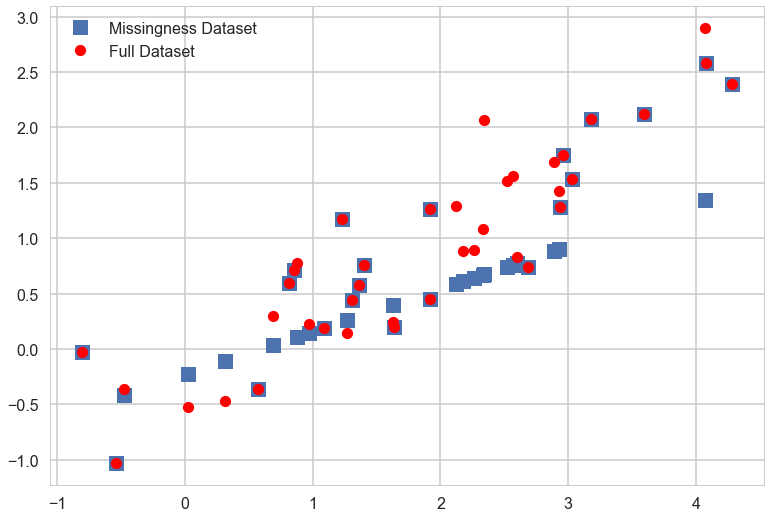

Means:
 1.84037225001 0.48065176832
SDs:
 1.24890962772 0.804534434368
Correlation:
 0.599613302922


In [9]:
samples_censored=np.copy(samples)
samples_censored[20:,1]=newys
plt.plot(samples_censored[:,0], samples_censored[:,1], 's', markersize=15, alpha=1, label="Missingness Dataset")
plt.plot(samples[:,0], samples[:,1], 'o', c='red',  alpha=1, label="Full Dataset")
plt.legend();
plt.show();

print("Means:\n",mu1s[1],mu2s[1])
print("SDs:\n",s1s[1],s2s[1])
print("Correlation:\n",rhos[1])

These estimates look a bit better than the all-zeros estimate.

### Looping
Now it's clear that we can repeat the E and M steps and hopefully get a less bogus estimate of the parameters and then a less bogus estimate of the missing data, and so on.

In [10]:
for step in range(1,20):
    samples_censored[20:,1] = newys
    #M-step
    mu1s.append(mu1(samples_censored))
    mu2s.append(mu2(samples_censored))
    s1s.append(s1(samples_censored))
    s2s.append(s2(samples_censored))
    rhos.append(rho(samples_censored))
    #E-step
    newys=ynew(samples_censored[20:,0], mu1s[step], mu2s[step], s1s[step], s2s[step], rhos[step])
df=pd.DataFrame.from_dict(dict(mu1=mu1s, mu2=mu2s, s1=s1s, s2=s2s, rho=rhos))

print("Means:\n", means)
print("Covariance Matrix:\n", cov)
df

Means:
 [ 1.85  1.  ]
Covariance Matrix:
 [[ 1.      0.615 ]
 [ 0.615   0.5625]]


,mu1,mu2,rho,s1,s2
0,1.840372,0.480652,0.599613,1.24891,0.804534
1,1.840372,0.480652,0.599613,1.24891,0.804534
2,1.840372,0.705390,0.868163,1.24891,0.757017
3,1.840372,0.705390,0.868163,1.24891,0.757017
4,1.840372,0.812111,0.921979,1.24891,0.779760
5,1.840372,0.812111,0.921979,1.24891,0.779760
6,1.840372,0.863477,0.933077,1.24891,0.792884
7,1.840372,0.863477,0.933077,1.24891,0.792884
8,1.840372,0.888485,0.935672,1.24891,0.797723
9,1.840372,0.888485,0.935672,1.24891,0.797723


Voila. We converge to stable values of our parameters.

But they may not be the ones we seeded the samples with. The EM algorithm is only good upto finding local minima, and a finite sample size also means that the minimum found can be slightly different.

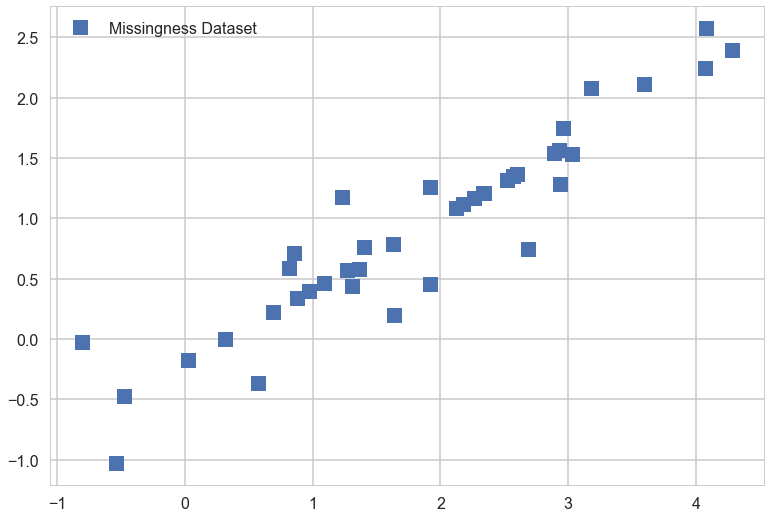

Means:
 1.84037225001 0.912566494281
SDs:
 1.24890962772 0.798955929091
Correlation:
 0.936398652852


In [11]:
samples_censored=np.copy(samples)
samples_censored[20:,1]=newys
plt.plot(samples_censored[:,0], samples_censored[:,1], 's', markersize=15, alpha=1, label="Missingness Dataset")
#plt.plot(samples[:,0], samples[:,1], 'o', c='red',  alpha=1, label="Full Dataset")
plt.legend();
plt.show();
print("Means:\n",mu1s[-1],mu2s[-1])
print("SDs:\n",s1s[-1],s2s[-1])
print("Correlation:\n",rhos[-1])

Looks like we're making reaonable guesses about the missing values, and the parameters.

**Warning** EM is about making the updates to the parameters. Imputing missing data as in this example is a nice educational conceit, but not fundamental to the algorithm. EMs can run entirely without assigning values to the Zs.

## The EM algorithm

** Expectation-maximization (EM)** method is an iterative method for maximizing difficult 
likelihood (or posterior) problems. It was first introduced by Dempster, Laird, and Rubin (1977). 

EM recognizes that if the data were fully observed, then  ML/ MAP estimates would be easy to compute. It thus alternates between inferring the missing values given the parameters (E step), and then optimizing the parameters given the “filled in” data (M step). 
The idea is to find a lower-bound 
on the log-likelihood $\ell$ (E-step) and the optimize the lower-bound (M-step). 

**We want to use EM wherever we dont know how to optimize simply the x-data likelihood.**

The EM algorithm is naturally useful for missing data, truncated data, censored data and grouped data problems. But it is also useful at places where you have clusters like mixture models, and you are working in an unsupervised or semi-supervised mode. Basically, any place you can set up a latent variable model or a data augmentation procedure, EM is useful.

There are applications in astronomical image analysis, genetics, engineering, etc

The basic idea is:

**calculate MLE estimates for the incomplete data problem by using the complete-data likelihood. To create complete data, augment the observed data with manufactured data**

Sorta like, just assign points to clusters to start with and iterate.

Then, at each iteration, replace the augmented data by its conditional expectation given current observed data and parameter estimates. (E-step) Maximize the full-data likelihood to do the M-step.



## Why is EM important?

We have motivated the EM algorithm using missing data and will continue to mixture models, but these are not its only place of use. 

Since MLE's can overfit, we often prefer to use MAP estimation which, essentially, includes a prior to regularize the likelihood. EM is a perfectly reasonable method for MAP estimation in mixture models; you just need to multiply in the prior.

Basically the EM algorithm has a similar setup to the data augmentation problem and can be used in any problem which has a similar structure. Suppose for example you have two parameters $\phi$ and $\gamma$ in a posterior estimation, with daya $y$. Say that we'd like to estimate the posterior $p(\phi  \vert  y)$. It may be relatively hard to estimate this, but suppose we can  work with $p(\phi  \vert  \gamma, y)$ and $p(\gamma  \vert  \phi, y)$. Then you can use the structure of the EM algorithm to estimate the marginal posterior of any one parameter. Start with:

$$log p(\phi  \vert  y) = log p(\gamma, \phi  \vert  y) - log p(\gamma  \vert  \phi, y)$$

Notice the similarity of this to the above expressions with $\phi$ as $x$, $y$ as $\theta$, and $\gamma$ as $z$. Thus the same derivations apply toany problem with this structure.

This structure can also be used in type-2 likelihood or emprical bayes estimation.